In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import anndata
from sklearn.decomposition import PCA

import torch
from torch import tensor as tt

from utils import *
from torch_models import *

from ipywidgets import interact


In [13]:
# load dataset
scDataa = pd.read_csv("data/111023_all.csv")


In [15]:
scData = scDataa.T
scData
col_names = scData.iloc[0, :].values

# # delete first row
scData = scData.drop(scData.index[0])
scData.columns = col_names
scData

# # create anndata object
E_sc = anndata.AnnData(scData)
E_sc.X = E_sc.X.astype(float)
# normalize over cell counts
E_sc.layers["norm"] = E_sc.X / E_sc.X.sum(axis=1).reshape(-1, 1)
E_sc.shape

(22360, 11231)

In [48]:
cell_IDs = E_sc.obs_names
genes = np.array(E_sc.var_names).astype(str)
genes


array(['Sox17', 'Tcea1', 'Rgs20', ..., 'Ostf1', 'Naa10', 'Mrps36'],
      dtype='<U18')

In [64]:
meta = pd.read_csv("data/111023_all_meta.csv", index_col="Unnamed: 0")  # , header=0)
meta.index

# mask that has True for cell index names which has light in the name
mask_light = [False if "light" in i else True for i in meta.index]
mask_light = np.array(mask_light)

meta.index[mask_light]  # .shape

meta = meta.iloc[mask_light, :]
cell_clusters_n = meta["seurat_clusters"].values
cell_types = meta["Idents.data.combined."].values

meta

,orig.ident,nCount_RNA,nFeature_RNA,nCount_spliced,nFeature_spliced,nCount_unspliced,nFeature_unspliced,percent.mt,percent.RP,percent.intron,integrated_snn_res.0.1,seurat_clusters,Idents.data.combined.
14_AAAACTACCCAG,SRR7535543Solo.out,529,367,529,367,72,62,1.701323,0.756144,0.119800,0,0,Oligodendrocytes
14_AAAAGGGGCCGT,SRR7535543Solo.out,913,685,913,685,72,66,1.861993,0.547645,0.073096,1,1,Neurons_1
14_AAACCACCCGGG,SRR7535543Solo.out,407,358,407,358,22,20,1.228501,0.737101,0.051282,3,3,Neurons_2
14_AAACGTAATTTT,SRR7535543Solo.out,313,269,313,269,18,18,1.597444,1.916933,0.054381,6,6,Ependymal_cells
14_AAACTAACCACA,SRR7535543Solo.out,572,382,572,382,56,52,1.923077,0.524476,0.089172,0,0,Oligodendrocytes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58_TTATAAATAGCA,SRR7535554Solo.out,515,368,515,368,48,45,1.747573,1.359223,0.085258,0,0,Oligodendrocytes
58_TTATAGCATGCC,SRR7535554Solo.out,482,325,482,325,53,52,1.867220,0.829876,0.099065,0,0,Oligodendrocytes
58_TTATAGGCGTCT,SRR7535554Solo.out,442,304,442,304,31,30,1.357466,1.131222,0.065539,0,0,Oligodendrocytes
58_TTATCAACTTAT,SRR7535554Solo.out,334,260,334,260,36,34,1.497006,0.000000,0.097297,2,2,Astrocytes


In [32]:
zonated_genes = np.loadtxt("zonated_list.txt", dtype=str)


In [49]:
not_include = ["Gm42418", "Gm26917", "Gapdh", "Ptp4a1", "Fam196a", "Chd3os", "Prokr2"]
# create mask of genes that are not in the dataset
# and remove them from the list
mask_sc = np.array([z not in not_include for z in zonated_genes])

# remove them from the list
sc_zon = zonated_genes[mask_sc]
data_z = E_sc[:, sc_zon]

In [51]:
# check if in E_sc there is nans
np.isnan(E_sc.layers["norm"]).sum()

stds = E_sc.layers["norm"].std(axis=0)
genes[stds == 0]

array(['Mrps36'], dtype='<U18')

# Studyng cell types

In [82]:
# do pca of data_z
pca = PCA(n_components=2)
# normalize and standardize data
data_stand = (
    E_sc.layers["norm"][:, stds != 0] - E_sc.layers["norm"].mean(axis=0)[stds != 0]
) / E_sc.layers["norm"].std(axis=0)[stds != 0]

pca.fit(data_stand)
pca_data = pca.transform(data_stand)

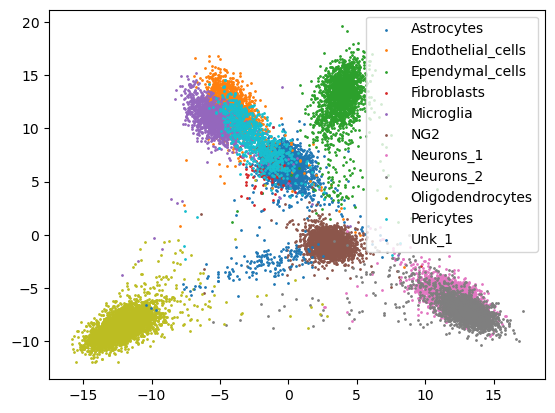

In [70]:
# plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cell_clusters_n, s =1)

# create a loop over cell types, plot separetly the pca for each cell type
cell_types_u = np.unique(cell_types)
cell_types_u

for c in cell_types_u:
    mask_c = cell_types == c
    plt.scatter(pca_data[mask_c, 0], pca_data[mask_c, 1], s=1, label=c)
plt.legend()


In [85]:
# create a vector wich has number of cells for each cell type
n_cells = np.zeros(len(cell_types_u))
# create pandas series with cell types as index
n_cells = pd.Series(n_cells, index=cell_types_u)
for i, c in enumerate(cell_types_u):
    n_cells[i] = np.sum(cell_types == c)

n_cells


Astrocytes           2833.0
Endothelial_cells    1911.0
Ependymal_cells      1826.0
Fibroblasts            76.0
Microglia            1333.0
NG2                  1937.0
Neurons_1            3473.0
Neurons_2            2392.0
Oligodendrocytes     5528.0
Pericytes             886.0
Unk_1                 165.0
dtype: float64

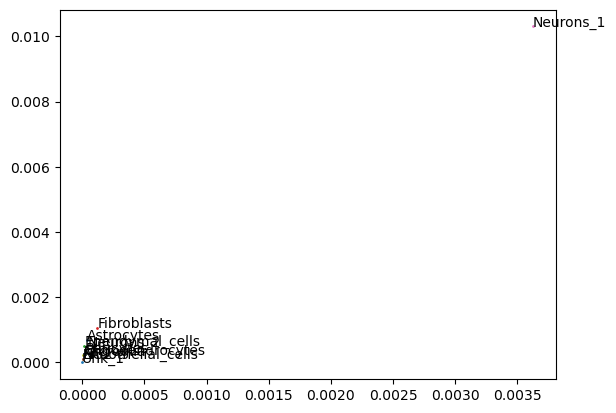

In [81]:
# now CHECK HOW ZONATED GENES ARE EXPRESSED IN EACH CELL TYPE
# let's check mean and variance of each gene in each cell type

# fix Vip an check cell types
gene = "Avp"
for c in cell_types_u:
    mask_c = cell_types == c
    mean = data_z[mask_c, "Vip"].layers["norm"].mean(axis=0)
    std = data_z[mask_c, "Vip"].layers["norm"].std(axis=0)
    plt.scatter(mean, std, s=1, label=c)
    # annotate cell type name
    plt.annotate(c, (mean, std))

In [88]:
# now create a loop over all genes, and than aover all cell types
# we want to create a matrix of mean and std for each gene in each cell type

# create a matrix of zeros
mean_tg = np.zeros((len(cell_types_u), len(sc_zon)))
# create pandas series with cell types as index
mean_tg = pd.DataFrame(mean_tg, index=cell_types_u, columns=sc_zon)
std_tg = mean_tg.copy()

for i, c in enumerate(cell_types_u):
    mask_c = cell_types == c
    mean_tg.loc[c, :] = data_z[mask_c, :].layers["norm"].mean(axis=0)
    std_tg.loc[c, :] = data_z[mask_c, :].layers["norm"].std(axis=0)

In [162]:
mean_tg.loc[["Oligodendrocytes", "Neurons_1"], :]

,Vip,Mbp,Meg3,Pgrmc1,Rorb,Hspa8,Ndrg4,Atp1a3,Rgs16,Syt10,...,AI593442,Ddc,Slc4a10,Gda,Map2k4,Cacna2d3,Ncdn,Atp8a1,Atp1a1,Avp
Oligodendrocytes,0.000010,0.008521,0.000012,0.000089,0.000009,0.000031,0.000028,0.000009,0.000002,0.000004,...,7.579498e-07,0.000111,0.000025,0.000006,0.000030,0.000005,0.000046,0.000492,0.000221,0.000039
Neurons_1,0.003625,0.000361,0.001947,0.001752,0.000498,0.000044,0.000497,0.000307,0.000694,0.000790,...,2.895559e-05,0.000073,0.000127,0.000317,0.000082,0.000198,0.000055,0.000246,0.000131,0.004861


In [150]:
# now let's take the mean matrix and for each gene
# extract in which cell type it has the highest mean

# create a vector of zeros
cell_type_max = np.zeros(len(sc_zon)).astype(str)
cell_type_max = pd.Series(cell_type_max, index=sc_zon)

for i, g in enumerate(sc_zon):
    cell_type_max[i] = mean_tg.loc[:, g].idxmax()

In [154]:
cell_type_max[cell_type_max == "Oligodendrocytes"]
# show all entries og cell_type_max
# that are different from the gene type

Mbp       Oligodendrocytes
Stmn1     Oligodendrocytes
Tmod2     Oligodendrocytes
Car2      Oligodendrocytes
Atp8a1    Oligodendrocytes
dtype: object

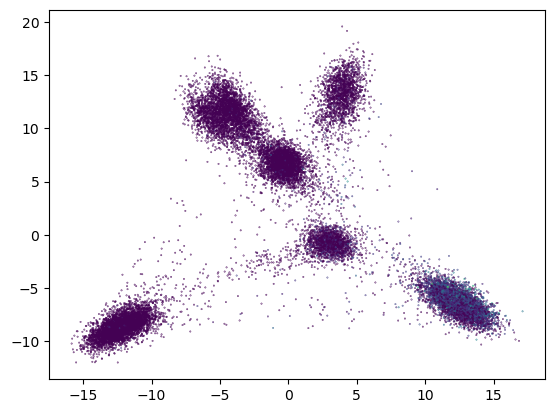

In [148]:
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=data_z[:, "Meg3"].layers["norm"], s=0.1)

# MLE 

In [130]:
# load theta_3D
theta_3D = pd.read_csv("fit/theta_3D_big.csv", index_col="Unnamed: 0")
# remove genes that are not in the dataset
theta_3D = theta_3D.loc[sc_zon, :]
theta_3D = theta_3D.astype(float)
theta_3D

,ax,bx,ay,by,az,bz,c
Vip,-0.321947,-0.158938,-0.498240,1.864120,-1.907390,1.073698,-5.818551
Mbp,-0.191845,0.544235,0.527028,0.403654,0.209967,-0.036305,-7.872315
Meg3,0.095555,-0.177527,0.098234,-0.023014,-0.057559,-0.293302,-6.214055
Pgrmc1,-0.067631,-0.101682,-0.088413,0.049292,-0.058151,0.141761,-5.997895
Rorb,0.025984,-0.235129,-0.052628,-0.067645,0.093285,-0.021279,-6.758348
...,...,...,...,...,...,...,...
Cacna2d3,-0.184114,-0.006946,-0.217365,0.335026,-0.476821,0.195226,-8.242718
Ncdn,-0.038447,0.237866,-0.049037,-0.073857,-0.038455,-0.075847,-8.554934
Atp8a1,-0.000655,-0.052249,-0.043217,0.132305,0.034473,0.065019,-8.104515
Atp1a1,0.033356,-0.164592,-0.106697,0.001725,0.070034,-0.147199,-8.666538


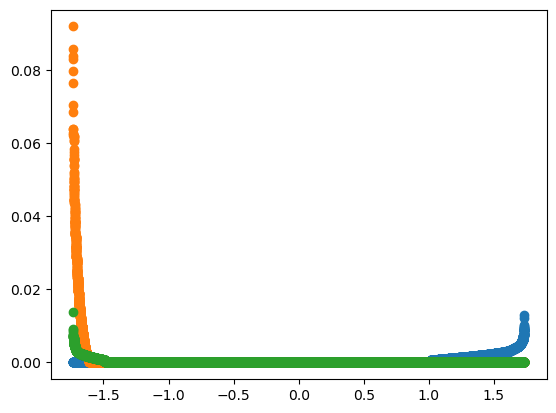

In [104]:
# now take a gene that grow MONOTONICALLY in space and get the argsort. This will give the order of the cells
# after standardize this position vecotr

# get the order of the cells
order_z = np.argsort(np.argsort(data_z[:, "Pgrmc1"].layers["norm"].squeeze()))
z_guess = (order_z - order_z.mean()) / order_z.std()
plt.scatter(z_guess, data_z[:, "Pgrmc1"].layers["norm"])

# same for y with gene Ndrg4
order_y = np.argsort(np.argsort(data_z[:, "Vip"].layers["norm"].squeeze()))
# here I put a negative sign tobecause the gene is DECREASES from the center to the periphery
y_guess = -(order_y - order_y.mean()) / order_y.std()
plt.scatter(y_guess, data_z[:, "Vip"].layers["norm"])

# same for x with gene Rorb
order_x = np.argsort(np.argsort(data_z[:, "Rorb"].layers["norm"].squeeze()))
x_guess = -(order_x - order_x.mean()) / order_x.std()

plt.scatter(x_guess, data_z[:, "Rorb"].layers["norm"])

In [186]:
n_counts = E_sc.X.sum(axis=1)
Y_counts = tt(data_z[:, :].X)

In [187]:
# filter and take only oligo and Neurons_1
mask_oligo = cell_types == "Oligodendrocytes"
mask_neur = cell_types == "Neurons_1"
mask_cell_type = mask_oligo | mask_neur

Y_counts = Y_counts[mask_cell_type, :]
sc_counts = tt(n_counts[mask_cell_type], dtype=torch.float32)
NC, NG = Y_counts.shape
Y_counts.shape

torch.Size([9001, 61])

In [218]:
new_ct = cell_types[mask_cell_type]
new_ct_bum = new_ct == "Oligodendrocytes"


In [196]:
# X = torch.randn(Y_counts.shape[0], 3, requires_grad=True)

# X = tt([x_guess, y_guess, z_guess]).T
X.requires_grad = True
# create X form the guesses

theta3 = tt(theta_3D.values)
# convert onated dataset to tesor

disp = tt(0.3, requires_grad=True)

# # gettign the constant and preparing the C parameter
# C = theta_3D[:,6].astype(np.dtype('float32'))
# C = tt(C)
# # repeat this vector N_sample ona  new dimension
# C = C.repeat(NS, 1)
# C.requires_grad = True

print(X.shape, theta3.shape, disp.shape, sc_counts.shape)


torch.Size([9001, 3]) torch.Size([61, 7]) torch.Size([]) torch.Size([9001])


In [206]:
# train model
X = torch.zeros(Y_counts.shape[0], 3, requires_grad=True)
optimizer = torch.optim.Adam([X, disp], lr=0.001)

losses = []

for step in range(3000):
    optimizer.zero_grad()  # zero the gradients
    output = model_3D_NB_batch(X, Y_counts, theta3, sc_counts, disp, batch_size=NC)
    output.backward()  # compute the gradients
    optimizer.step()  # update the variable
    losses.append(output.detach())


disp  1.0586181
tensor(304431.4634, dtype=torch.float64)


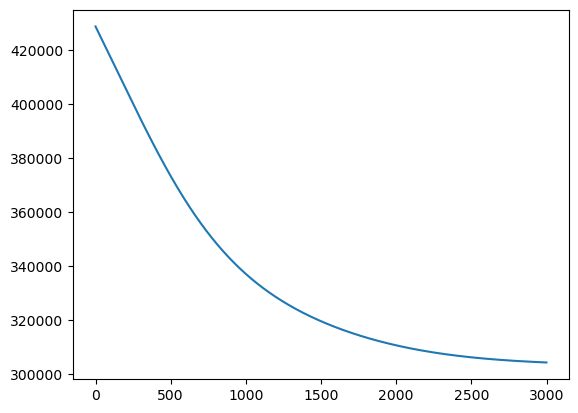

In [207]:
print("disp ", disp.detach().numpy())
print(losses[-1])
plt.plot(losses[0000:])


In [209]:
x_train = X.clone().detach().numpy()
# C_train = C.clone().detach().numpy()
model_2D_NB(X, Y_counts, theta3, sc_counts, disp)


tensor(1459391.5413, dtype=torch.float64, grad_fn=<NegBackward0>)

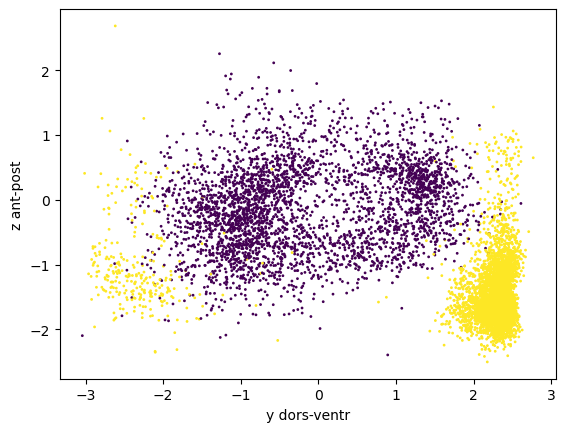

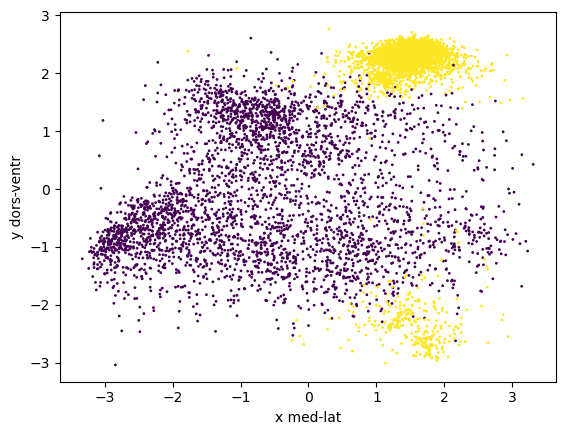

Text(0, 0.5, 'z ant-post')

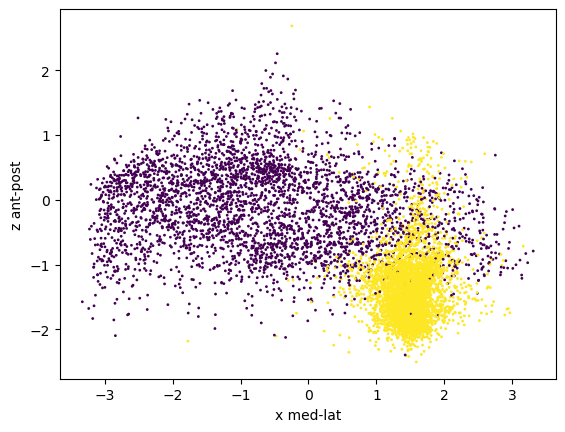

In [220]:
space_labels = np.array(["med-lat", "dors-vent", "ant-post"])

gene = "Avp"
plt.scatter(
    x_train[:, 1],
    x_train[:, 2],
    # c=data_z[:, gene].layers["norm"].squeeze()[mask_cell_type],
    c = new_ct_bum,
    s=1,
)
# plt.scatter(x_train[:, 0], x_train[:, 1], c = sample_index, s=2)
plt.xlabel("y dors-ventr")
plt.ylabel("z ant-post")
plt.show()

# now x and y
plt.scatter(
    x_train[:, 0],
    x_train[:, 1],
    # c=data_z[:, gene].layers["norm"].squeeze()[mask_cell_type],
    c = new_ct_bum,
    s=1,
)
# plt.scatter(x_train[:, 0], x_train[:, 1], c = sample_index, s=2)
plt.xlabel("x med-lat")
plt.ylabel("y dors-ventr")
plt.show()

# now x and z
plt.scatter(
    x_train[:, 0],
    x_train[:, 2],
    # c=data_z[:, gene].layers["norm"].squeeze()[mask_cell_type],
    c = new_ct_bum,
    s=1,
)
plt.xlabel("x med-lat")
plt.ylabel("z ant-post")
# plt.scatter(x_train[:, 0], x_train[:, 1], c = sample_index, s=2)

In [ ]:
], s=1
)
# plt.scatter(x_train[:, 0], x_train[:, 1], c = sample_index, s=2)
plt.xlabel("y dors-ventr")
plt.ylabel("z ant-post")
plt.show()

# now x and y
plt.scatter(
    x_train[:, 0], x_train[:, 1], c=data_z[:, gene].layers["norm"].squeeze()[mask_cell_type

In [ ]:
], s=1
)
# plt.scatter(x_train[:, 0], x_train[:, 1], c = sample_index, s=2)
plt.xlabel("x med-lat")
plt.ylabel("y dors-ventr")
plt.show()

# now x and z
plt.scatter(
    x_train[:, 0], x_train[:, 2], c=data_z[:, gene].layers["norm"].squeeze()[mask_cell_type

In [ ]:
], s=1
)
plt.xlabel("x med-lat")
plt.ylabel("z ant-post")
# plt.scatter(x_train[:, 0], x_train[:, 1], c = sample_index, s=2)